# Wild Fire Prediction Model

## Setup

In [ ]:
%pip install -r requirements.txt

: 

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from xgboost import XGBClassifier

: 

In [3]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Put the data in a Dataframe
df = pd.read_csv("../../data/final_data/total_data.csv")

## Verification

In [5]:
# Dataframe shape
df.shape

(4198, 88)

In [6]:
# Checking for null values
df.isnull().sum()

DayAirTmpAvg01    8
DayAirTmpAvg02    8
DayAirTmpAvg03    5
DayAirTmpAvg04    5
DayAirTmpAvg05    6
                 ..
is_fire           0
CBD_VALUE         0
EVC_VALUE         0
FDIST_VALUE       0
FVC_VALUE         0
Length: 88, dtype: int64

In [7]:
# Makes sure is_fire only contained 0s and 1s
df['is_fire'].nunique()

2

In [8]:
# Making sure date format all match
try:
    pd.to_datetime(df["date"], utc=True)
    print("Consistent date formats")
except:
    print("Inconsistent date formats")

Consistent date formats


## Data Processing

### With Deep Learning

In [9]:
columns_to_fix = df.select_dtypes(include='number').columns[df.select_dtypes(include='number').isnull().any()].tolist()
print(columns_to_fix)

['DayAirTmpAvg01', 'DayAirTmpAvg02', 'DayAirTmpAvg03', 'DayAirTmpAvg04', 'DayAirTmpAvg05', 'DayAirTmpAvg06', 'DayAirTmpAvg07', 'DayAirTmpAvg08', 'DayAirTmpAvg09', 'DayAirTmpAvg10', 'DayAirTmpAvg11', 'DayAirTmpAvg13', 'DayAirTmpAvg14', 'DayPrecip01', 'DayPrecip02', 'DayPrecip04', 'DayPrecip05', 'DayPrecip06', 'DayPrecip07', 'DayPrecip08', 'DayPrecip09', 'DayPrecip11', 'DayPrecip14', 'DayRelHumAvg01', 'DayRelHumAvg02', 'DayRelHumAvg03', 'DayRelHumAvg04', 'DayRelHumAvg05', 'DayRelHumAvg06', 'DayRelHumAvg07', 'DayRelHumAvg08', 'DayRelHumAvg09', 'DayRelHumAvg10', 'DayRelHumAvg11', 'DayRelHumAvg12', 'DayRelHumAvg13', 'DayRelHumAvg14', 'DaySoilTmpAvg01', 'DaySoilTmpAvg02', 'DaySoilTmpAvg03', 'DaySoilTmpAvg04', 'DaySoilTmpAvg05', 'DaySoilTmpAvg06', 'DaySoilTmpAvg07', 'DaySoilTmpAvg08', 'DaySoilTmpAvg09', 'DaySoilTmpAvg10', 'DaySoilTmpAvg11', 'DaySoilTmpAvg12', 'DaySoilTmpAvg13', 'DaySoilTmpAvg14', 'DayWindSpdAvg01', 'DayWindSpdAvg02', 'DayWindSpdAvg04', 'DayWindSpdAvg05', 'DayWindSpdAvg06', 'D

In [10]:
# Simple Autoencoder NN to help with filling in missing data
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32,16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward (self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [11]:
# Training Autoencoder to predict column using other columns as feature
def train_autoencoder(X, y, input_dim, num_epochs=30, batch_size=32):
    """
    Parameters:
    - X : input features (all cols except target)
    - y : target col to predict
    - input_dim : number of features in X
    - num_epochs : number of epochs
    - batch_size : batch size
    """
    model = Autoencoder(input_dim).to(device)
    criterion = nn.MSELoss()    # Measure how far model output is from y
    optimizer = optim.Adam(model.parameters(), lr=0.001)    # Common use optimizer

    # Convert X and y to PyTorch tensors and randomizes the order of the data / epoch
    X_tensor = torch.FloatTensor(X).to(device)
    y_tensor = torch.FloatTensor(y).reshape(-1, 1).to(device)
    dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in range(num_epochs):
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad() # Reset gradients
            output = model(batch_X) # Forward pass
            loss = criterion(output, batch_y) # Compute loss
            loss.backward() # Backward pass
            optimizer.step() # Update weights

        # if (epoch + 1) % 10 == 0:
        #     print(f"Epoch: {epoch + 1}, Loss: {loss.item():.4f}")
            
    return model

In [12]:
def fill_in_values(df, target_col, other_cols):
    """
    Parameters:
    - df : DataFrame to work on
    - target_col : col trying to fill
    - other_col : all other columns
    """

    # Replace NaNs with 0
    X = df[other_cols].fillna(0).values
    y = df[target_col].fillna(0).values

    # Scales the values with StandardScaler for efficiency and accuracy
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

    # Model training
    model = train_autoencoder(X_scaled, y_scaled, input_dim=len(other_cols))

    # Model evaluations
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X_scaled).to(device)
        predictions = model(X_tensor).cpu().numpy().flatten()
        predictions = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()
    
    # Fill in missing values
    missing_mask = df[target_col].isna()
    df.loc[missing_mask, target_col] = predictions[missing_mask]
    
    return df

In [13]:
for target_col in columns_to_fix:
    if target_col[-2:] == "01":
        print(f"Filling in values for {target_col[:-2]}")
    other_cols = [col for col in columns_to_fix if col != target_col]
    df = fill_in_values(df, target_col, other_cols)

df.isnull().sum()

Filling in values for DayAirTmpAvg
Filling in values for DayPrecip
Filling in values for DayRelHumAvg
Filling in values for DaySoilTmpAvg
Filling in values for DayWindSpdAvg


DayAirTmpAvg01    0
DayAirTmpAvg02    0
DayAirTmpAvg03    0
DayAirTmpAvg04    0
DayAirTmpAvg05    0
                 ..
is_fire           0
CBD_VALUE         0
EVC_VALUE         0
FDIST_VALUE       0
FVC_VALUE         0
Length: 88, dtype: int64

In [14]:
numeric_cols = df.select_dtypes(include=['number'])
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)

    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

In [15]:
df = pd.read_csv('datasets/checkpoint1.csv')
df['date'] = pd.to_datetime(df['date'], errors='coerce', utc=True)

# Extract features
df[f'date_year'] = df['date'].dt.year
df[f'date_month'] = df['date'].dt.month
df[f'date_day'] = df['date'].dt.day

# Fill missing values with mode or a safe fallback
for col in [f'date_year', f'date_month', f'date_day']:
    if df[col].isna().any():
        mode_val = df[col].mode(dropna=True)
        fallback = mode_val[0] if not mode_val.empty else 0
        df[col] = df[col].fillna(fallback)

df.drop('date',axis=1)
df.isnull().sum()
df.shape

(4198, 91)

In [16]:
df.to_csv('datasets/checkpoint2.csv', index=False)

## Prediction Model

In [17]:
df = pd.read_csv('datasets/checkpoint2.csv')
df.head(5)

,DayAirTmpAvg01,DayAirTmpAvg02,DayAirTmpAvg03,DayAirTmpAvg04,DayAirTmpAvg05,DayAirTmpAvg06,DayAirTmpAvg07,DayAirTmpAvg08,DayAirTmpAvg09,DayAirTmpAvg10,...,wildfire_hazard_potential,acres_burned,is_fire,CBD_VALUE,EVC_VALUE,FDIST_VALUE,FVC_VALUE,date_year,date_month,date_day
0,25.8,19.7,20.7,22.4,23.4,24.8,26.3,22.8,18.9,19.4,...,141,0.0,0,1,251,112,125,2022,6,2
1,25.5,25.3,24.5,21.9,27.5,28.4,31.0,23.9,24.1,24.6,...,1869,0.0,0,1,251,112,125,2022,8,12
2,11.0,14.5,14.4,13.1,11.4,11.3,8.8,10.0,9.3,6.3,...,3128,0.0,0,16,166,112,106,2010,1,27
3,9.3,13.6,14.7,12.2,8.9,9.8,9.5,9.7,9.4,14.2,...,6372,0.0,0,1,351,113,105,2012,12,2
4,24.9,24.4,26.0,27.5,25.7,24.9,23.9,23.3,22.8,23.3,...,6033,0.0,0,11,176,113,114,2013,9,11


In [ ]:
# Split data based on date_year
test_condition = df['date_year'] > 2021
train_condition = ~test_condition

excluded_cols = [
    'date',
    'is_fire',
    'acres_burned',
    'burn_probability',
    'conditional_flame_length',
    'conditional_risk_to_structures',
    'distance_km',
    'exposure',
    'flame_length_exceedance_4ft',
    'flame_length_exceedance_8ft',
    'risk_to_structures',
    'longitude',
    'latitude',
    'date_year',
]

# Features and labels
feature_cols = [col for col in df.columns if col not in excluded_cols]
X = df[feature_cols].values
y = df["is_fire"].values.reshape(-1, 1)

# Split into train and test sets based on date_year
X_train = X[train_condition]
X_test = X[test_condition]
y_train = y[train_condition]
y_test = y[test_condition]

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) 

C:\Users\Ken Zhang\AppData\Local\Temp\ipykernel_5584\4222586818.py:29: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.barplot(x="Metric", y="Score", hue="Model", data=melted, palette=palette)


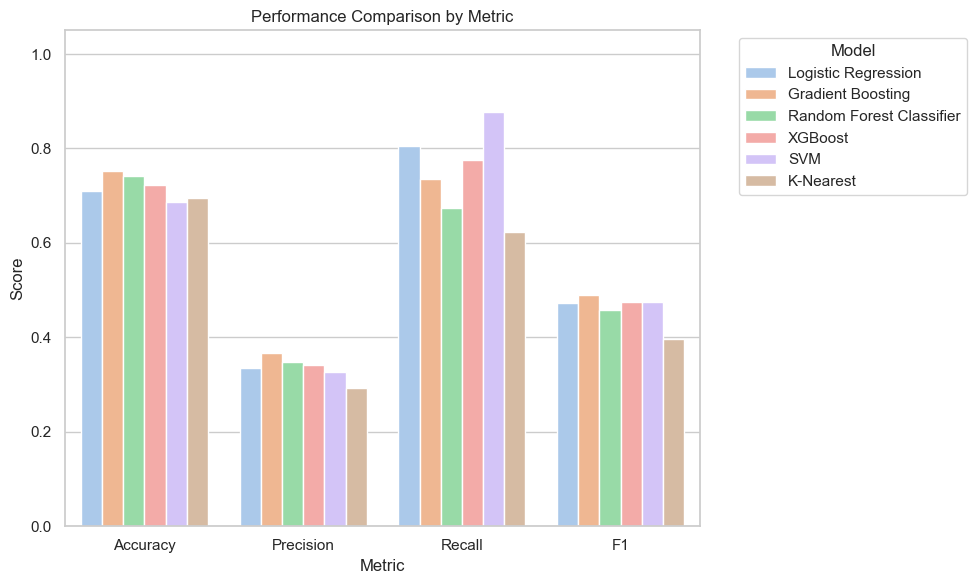

In [94]:
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "Gradient Boosting": HistGradientBoostingClassifier(),
    "Random Forest Classifier": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(scale_pos_weight=5),
    "SVM": SVC(kernel='rbf', class_weight='balanced', probability=True),
    "K-Nearest": KNeighborsClassifier(n_neighbors=5)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train.ravel())
    predictions = model.predict(X_test)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, predictions),
        "Precision": precision_score(y_test, predictions),
        "Recall": recall_score(y_test, predictions),
        "F1": f1_score(y_test, predictions)
    })

results_df = pd.DataFrame(results)
melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
palette = sns.color_palette("pastel") 

plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")
sns.barplot(x="Metric", y="Score", hue="Model", data=melted, palette=palette)
plt.title("Performance Comparison by Metric")
plt.ylim(0, 1.05)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
